In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from ray import train, tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from sklearn.metrics import mean_absolute_error


In [2]:
file_path = "/mnt/12TB/jet_omer/cms_jet_data.h5"
key = "data"
data = pd.read_hdf(file_path, key=key)

df = pd.DataFrame(data)
df_filtered = df[(df["jetGenMatch"] != 0) & (df["genJetPt"] > 20) & (abs(df["jetEta"]) < 2.5)]
df_filtered = df_filtered.head(1000000)

exclude_columns = ["genJetPt", "jetPt", "jetGenMatch"]

In [3]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd


features = df_filtered[[col for col in df_filtered.columns if col not in exclude_columns]]
target = df_filtered["genJetPt"]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features_scaled, target, test_size=0.4, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_jet_train, X_jet_temp, y_jet_train, y_jet_temp = train_test_split(df_filtered["jetPt"], target, test_size=0.4, random_state=42)
X_jet_validation, X_jet_test, y_jet_validation, y_jet_test = train_test_split(X_jet_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_validation, label=y_validation)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 10,
    'alpha': 0,
    'n_estimators': 100,
}

""" # Define the hyperparameters grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 15],
    'n_estimators': [50, 100, 150],
}

# Create XGBoost regressor
xgb_regressor = xgb.XGBRegressor(**params)

# Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=1)
grid_search.fit(features_scaled, target)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Negative Mean Absolute Error:", grid_search.best_score_)

# Get the best model from the grid search
best_xgb_model = grid_search.best_estimator_ """


' # Define the hyperparameters grid for grid search\nparam_grid = {\n    \'learning_rate\': [0.01, 0.1, 0.2],\n    \'max_depth\': [5, 10, 15],\n    \'n_estimators\': [50, 100, 150],\n}\n\n# Create XGBoost regressor\nxgb_regressor = xgb.XGBRegressor(**params)\n\n# Grid Search with cross-validation\ngrid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring=\'neg_mean_absolute_error\', cv=3, verbose=1)\ngrid_search.fit(features_scaled, target)\n\n# Print the best parameters and best score\nprint("Best Parameters:", grid_search.best_params_)\nprint("Best Negative Mean Absolute Error:", grid_search.best_score_)\n\n# Get the best model from the grid search\nbest_xgb_model = grid_search.best_estimator_ '

In [4]:
best_params = {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150}

# Update the params dictionary
params.update(best_params)

evals_result = {}

# Train the final model with the best parameters
final_model = xgb.train(params, dtrain, num_boost_round=150, evals=[(dtrain, 'train'), (dvalid, 'valid')], evals_result=evals_result, early_stopping_rounds=10, verbose_eval=True)

[0]	train-rmse:268.26365	valid-rmse:268.98259
[1]	train-rmse:246.99418	valid-rmse:247.83846


/home/odokumaci/miniconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:57:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	train-rmse:228.26498	valid-rmse:229.24535
[3]	train-rmse:206.07935	valid-rmse:206.98439
[4]	train-rmse:186.18073	valid-rmse:187.02747
[5]	train-rmse:170.11336	valid-rmse:170.99557
[6]	train-rmse:153.98773	valid-rmse:154.83876
[7]	train-rmse:139.47933	valid-rmse:140.31886
[8]	train-rmse:126.53717	valid-rmse:127.37572
[9]	train-rmse:114.91933	valid-rmse:115.77640
[10]	train-rmse:104.53614	valid-rmse:105.40926
[11]	train-rmse:95.33971	valid-rmse:96.23300
[12]	train-rmse:87.17380	valid-rmse:88.09877
[13]	train-rmse:79.86021	valid-rmse:80.82961
[14]	train-rmse:74.25537	valid-rmse:75.34804
[15]	train-rmse:68.40033	valid-rmse:69.60085
[16]	train-rmse:63.22415	valid-rmse:64.56908
[17]	train-rmse:59.42025	valid-rmse:60.92249
[18]	train-rmse:55.40302	valid-rmse:57.07554
[19]	train-rmse:51.83778	valid-rmse:53.70059
[20]	train-rmse:48.68294	valid-rmse:50.72899
[21]	train-rmse:47.00965	valid-rmse:49.23428
[22]	train-rmse:45.04057	valid-rmse:47.48525
[23]	train-rmse:42.89807	valid-rmse:45.52882


Mean Absolute Error on test set (XGBoost): 16.13230323791504


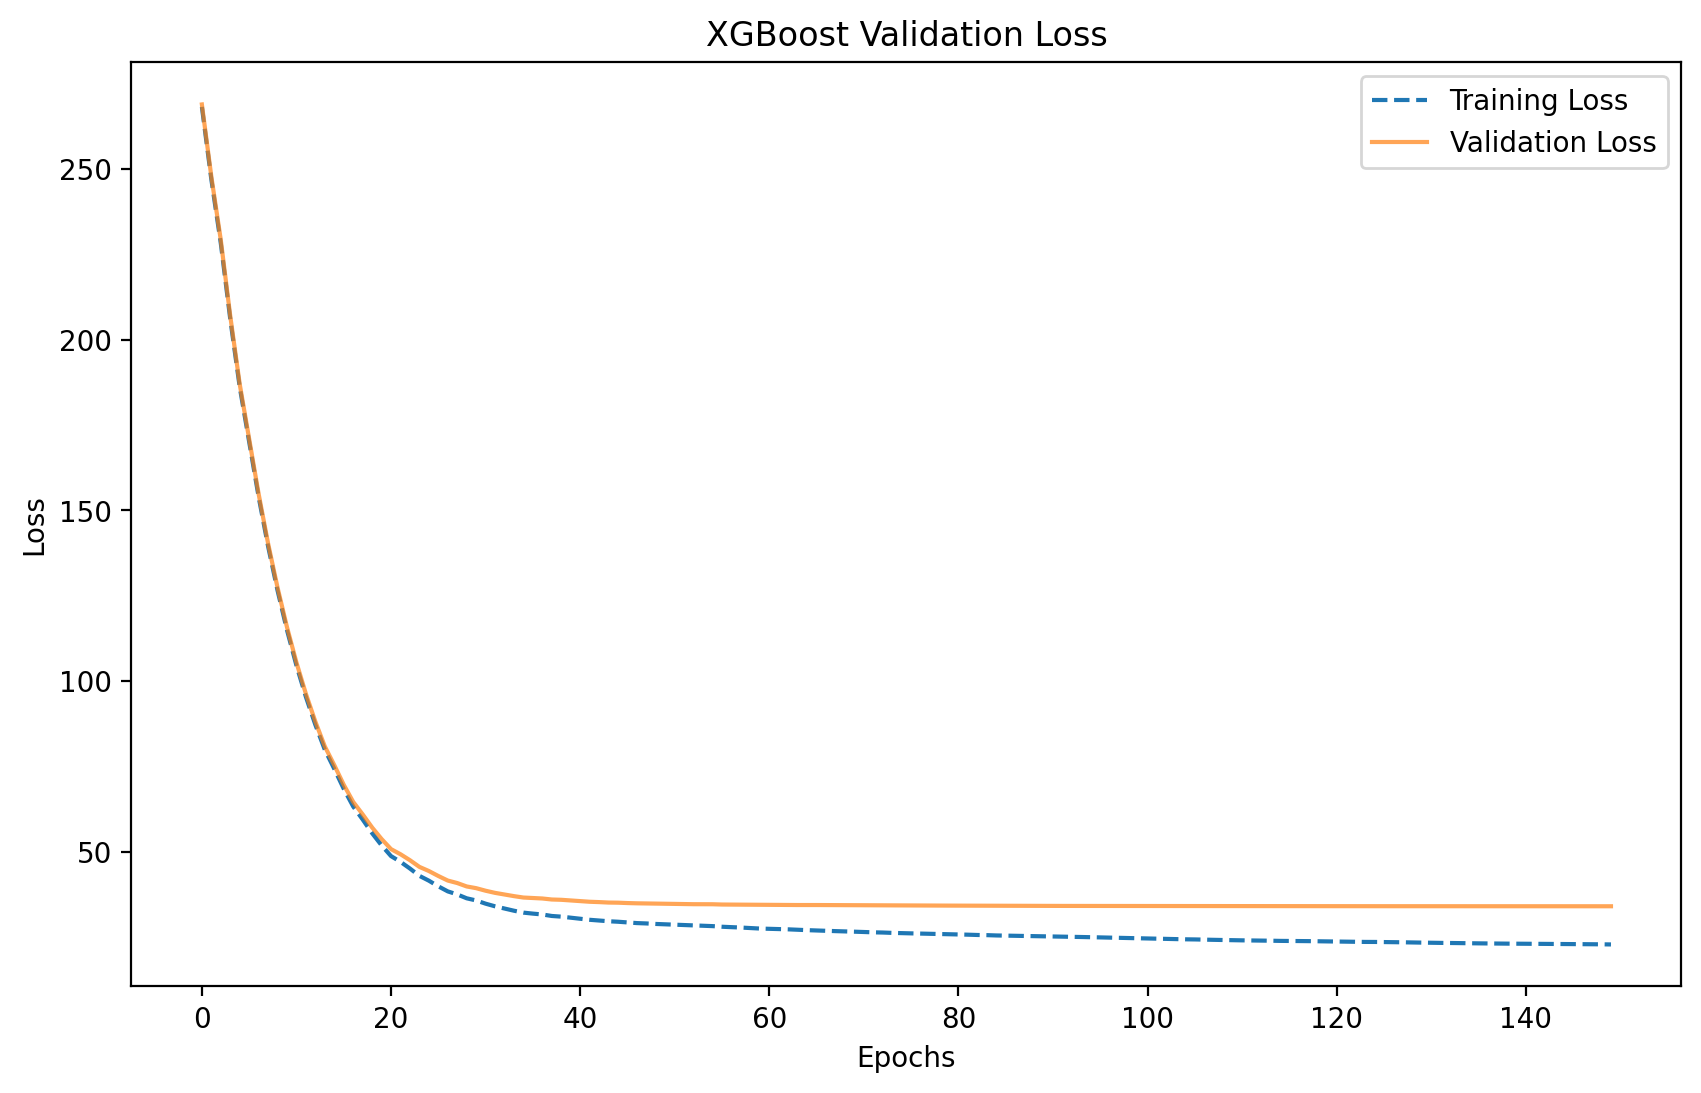

In [5]:
y_pred = final_model.predict(dtest)



#mae_xgb = mean_absolute_error(y_test, y_pred)
mae_xgb = np.mean(np.abs(y_test - y_pred))
print(f'Mean Absolute Error on test set (XGBoost): {mae_xgb}')



train_mae = evals_result['train']['rmse']
valid_mae = evals_result['valid']['rmse']

plt.figure(figsize=(10, 6))

plt.plot(train_mae, label='Training Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('XGBoost Training Loss')
plt.legend()

plt.plot(valid_mae, label='Validation Loss', alpha = 0.7)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('XGBoost Validation Loss')
plt.legend()

plt.show()

In [8]:

def bin_ratio(basejet_hist, genjet_hist):
    

    log_bins = np.logspace(np.log10(genjet_hist.min()), np.log10(genjet_hist.max()), 50)
    _, bin_edges = np.histogram(genjet_hist, bins=log_bins)

    ratios = []
    mean_list = []
    std_list = []
    iqr_list = []  # List to store interquartile ranges
    median_list = []  # List to store medians

    for ibin in range(len(bin_edges) - 1):
        idx = (basejet_hist >= bin_edges[ibin]) & (basejet_hist <= bin_edges[ibin + 1])  # boolean mask
        ratios.append((basejet_hist[idx] - 0 * genjet_hist[idx]) / genjet_hist[idx])

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    for hist in ratios:
        if len(hist) > 0:  # Check if hist is not empty
            mean_list.append(np.mean(hist))
            std_list.append(np.std(hist))
            iqr = np.percentile(hist, 75) - np.percentile(hist, 25)  # Interquartile range calculation
            iqr_list.append(iqr)
            median_list.append(np.median(hist))
        else:
            mean_list.append(np.nan)  # Append NaN if hist is empty
            std_list.append(np.nan)
            iqr_list.append(np.nan)
            median_list.append(np.nan)

    iqr_ratio = np.array(iqr_list) / np.array(median_list)  # Calculating IQR ratio

    return np.array(mean_list), np.array(std_list), bin_centers, bin_edges, iqr_ratio



basetogen_mean, basetogen_std, bin_centers, bin_edges, basetogen_iqr_ratio = bin_ratio(X_jet_test, y_test)
corrtogen_mean, corrtogen_std, _, _, corrtogen_iqr_ratio = bin_ratio(y_pred.flatten(), y_test)

# Check for division by zero and NaN values
valid_indices = (basetogen_iqr_ratio != 0) & (~np.isnan(corrtogen_iqr_ratio)) & (~np.isnan(basetogen_iqr_ratio))

# Calculate the ratio difference only for valid indices
beta = np.zeros_like(basetogen_iqr_ratio)
beta[valid_indices] = 1 - (corrtogen_iqr_ratio[valid_indices] / basetogen_iqr_ratio[valid_indices])

np.save('/home/odokumaci/git_repo/correction-repo/xg_corriqr.npy', corrtogen_iqr_ratio)
np.save('/home/odokumaci/git_repo/correction-repo/xg_corrtogen.npy', corrtogen_mean)
np.save('/home/odokumaci/git_repo/correction-repo/xg_baseiqr.npy', y_pred)
print(bin_centers)

[  21.14705629   23.55929124   26.24668871   29.24063638   32.57610228
   36.29204323   40.43185984   45.04390344   50.18204071   55.90628293
   62.28348682   69.38813541   77.30320799   86.12114925   95.94494899
  106.88934504  119.08216329  132.66581069  147.79893848  164.65829517
  183.4407909   204.36579725  227.67770941  253.64880063  282.58240224
  314.81644643  350.72741317  390.7347273   435.30565729  484.96077269
  540.28002419  601.90951717  670.56905797  747.0605609   832.27741426
  927.21491475 1032.9818921  1150.81365973 1282.08644272 1428.33345146
 1591.26278899 1772.77740085 1974.9973007  2200.28433119 2451.26974926
 2730.88495812 3042.3957448  3389.44042312 3776.07232772]


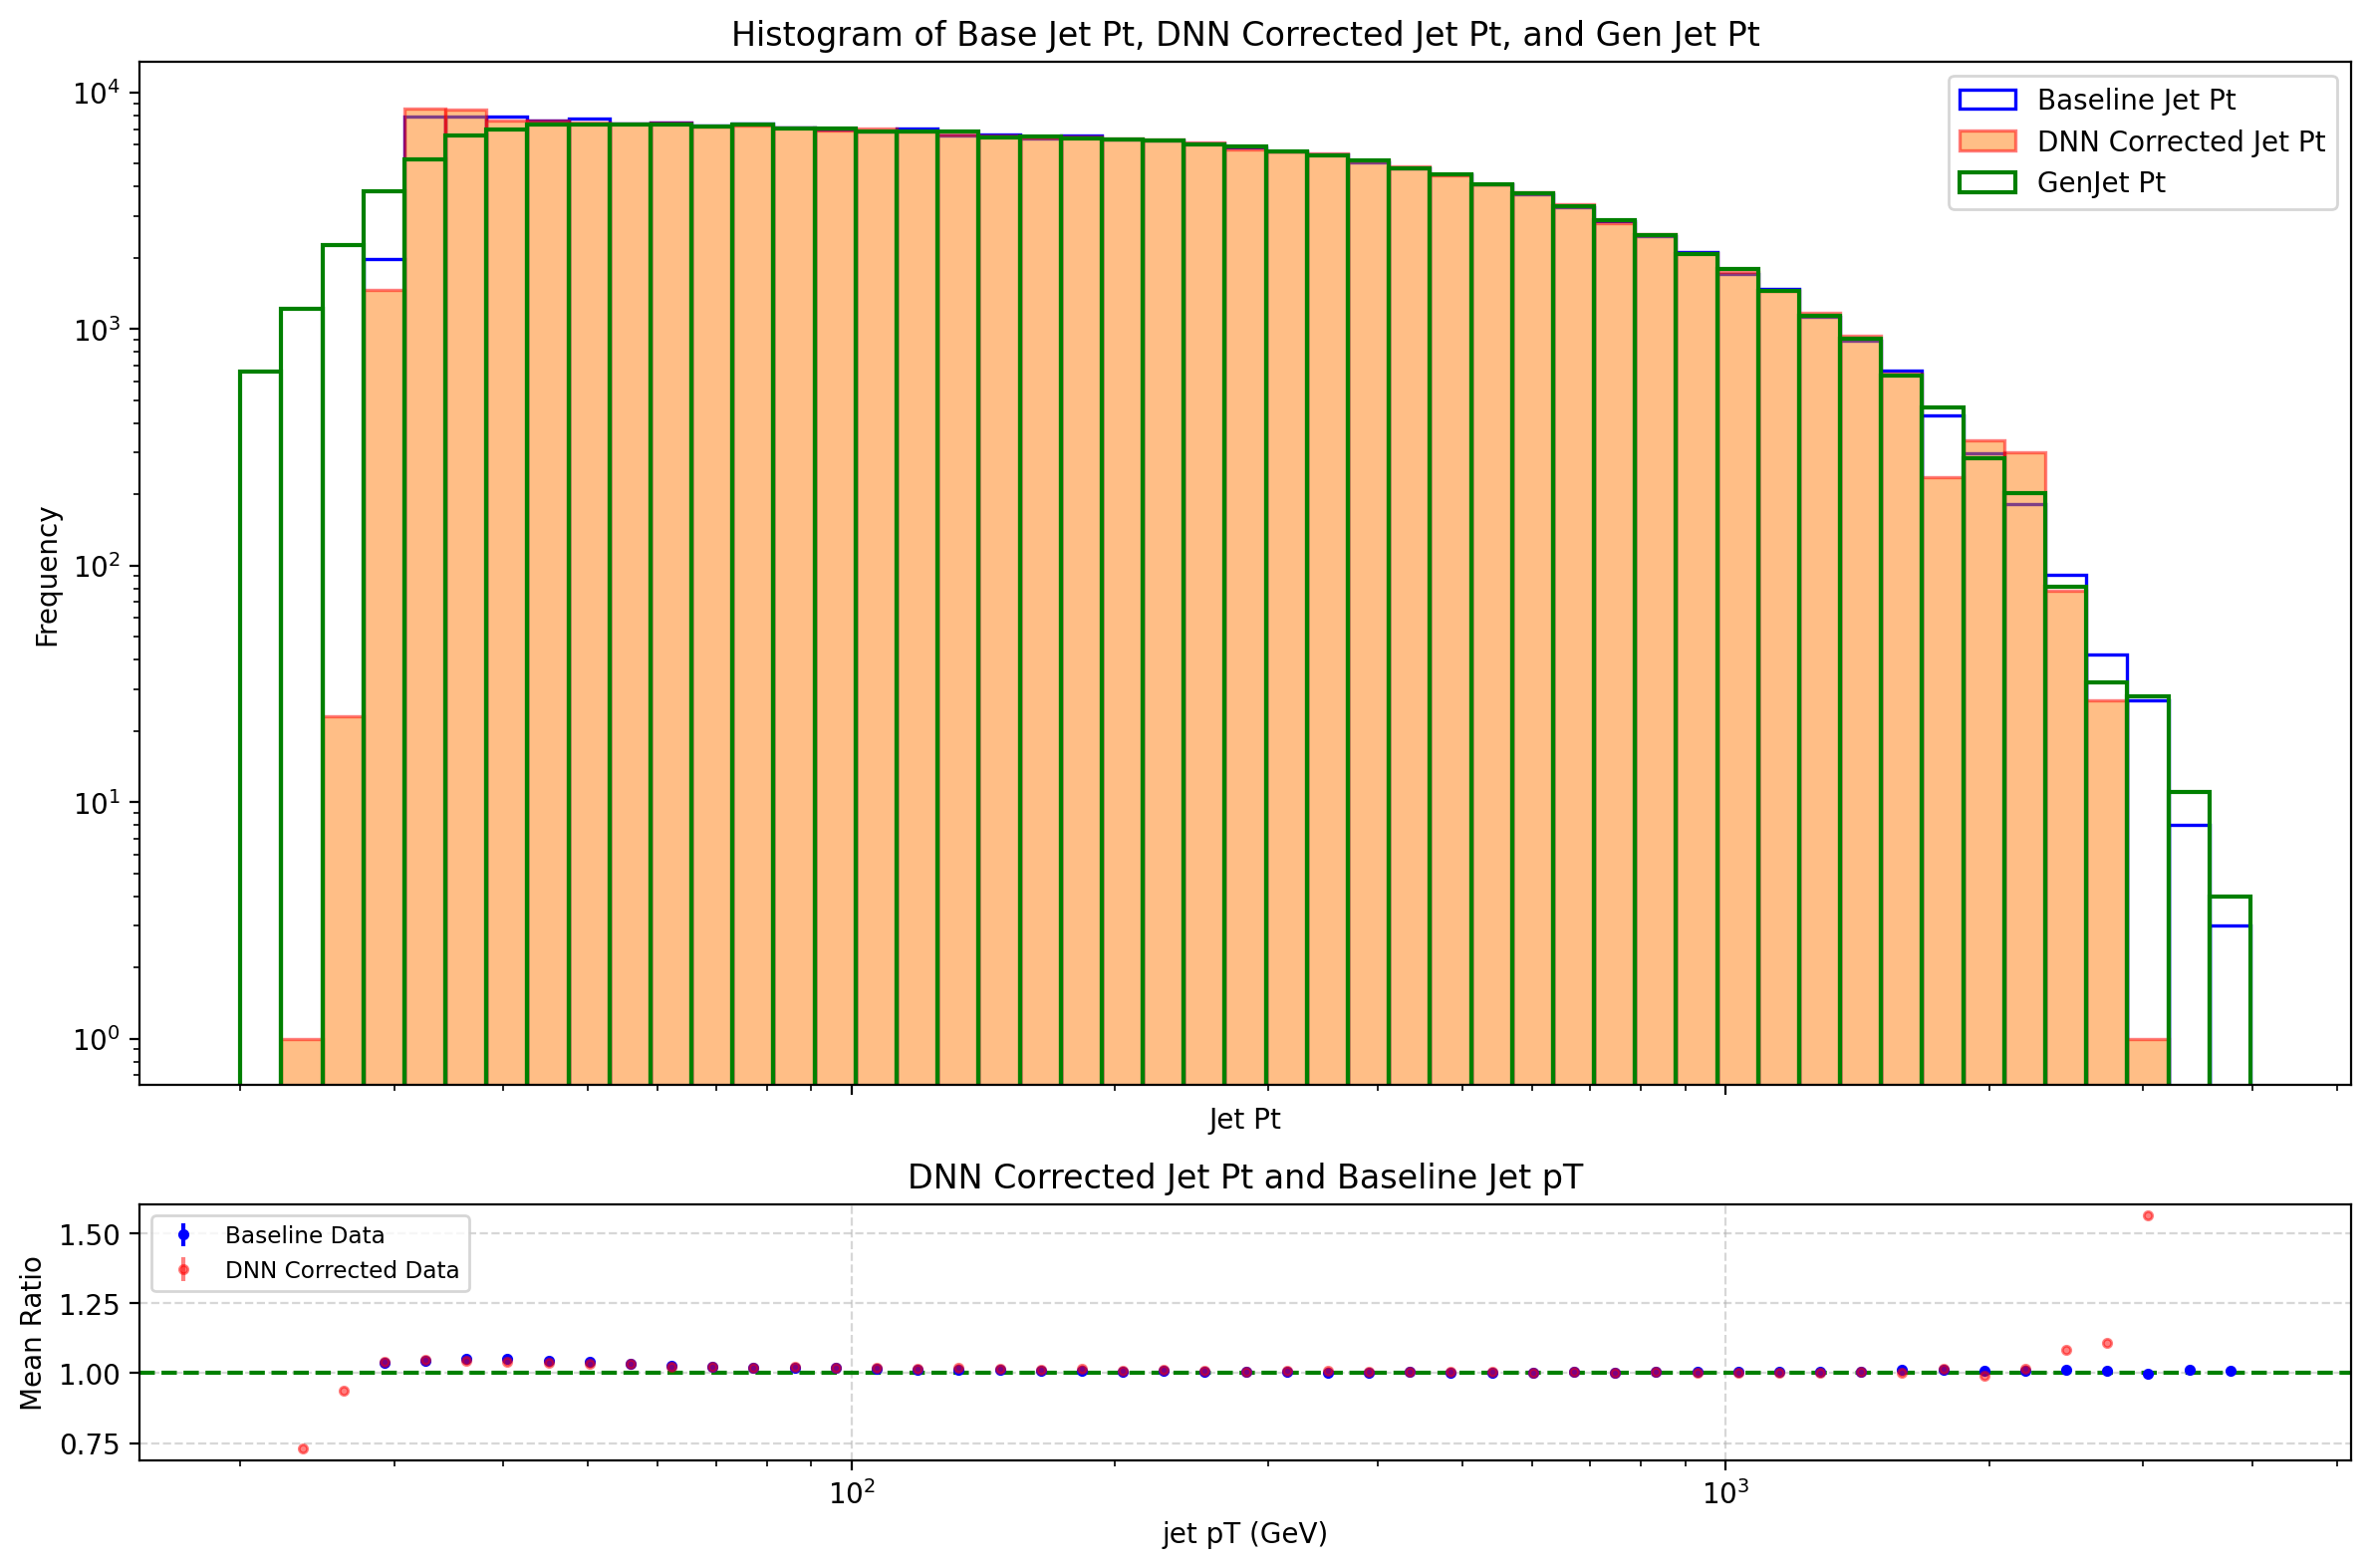

In [9]:
# Plotting the histogram and ratio plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', gridspec_kw={'height_ratios': [4, 1]}, figsize=(12, 8))


#common_bin_edges = np.linspace(min(X_test_original_scale[:, 0].min(), y_pred.min(), y_test.min()), max(X_test_original_scale[:, 0].max(), y_pred.max(), y_test.max()), 100)

ax1.hist(X_jet_test, bins=bin_edges, label='Baseline Jet Pt', fill=0, edgecolor='blue', linewidth=1.2)
ax1.hist(y_pred, bins=bin_edges, label='DNN Corrected Jet Pt', edgecolor="red", alpha=0.5, linewidth=1.2)
ax1.hist(y_test, bins=bin_edges, label='GenJet Pt', fill=0, edgecolor='green', linewidth=1.5)

ax1.set_xlabel('Jet Pt')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Base Jet Pt, DNN Corrected Jet Pt, and Gen Jet Pt')
ax1.set_yscale('log')
ax1.legend()


ax2.errorbar(bin_centers, basetogen_mean, yerr=0 * basetogen_std, fmt='o', markersize=3.0, color='blue', label='Baseline Data')
ax2.errorbar(bin_centers, corrtogen_mean, yerr=0 * corrtogen_std, fmt='o', markersize=3.0, alpha=0.5, color='red', label='DNN Corrected Data')
ax2.axhline(y=1.0, color='g', linestyle='--')

ax2.set_xlabel('jet pT (GeV)')
ax2.set_ylabel('Mean Ratio')
ax2.set_title('DNN Corrected Jet Pt and Baseline Jet pT')
ax2.set_xscale('log')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend(fontsize='small')

#ax1.set_xlim(0, 2500)
#ax2.set_xlim(0, 2500)

plt.tight_layout()
plt.show()